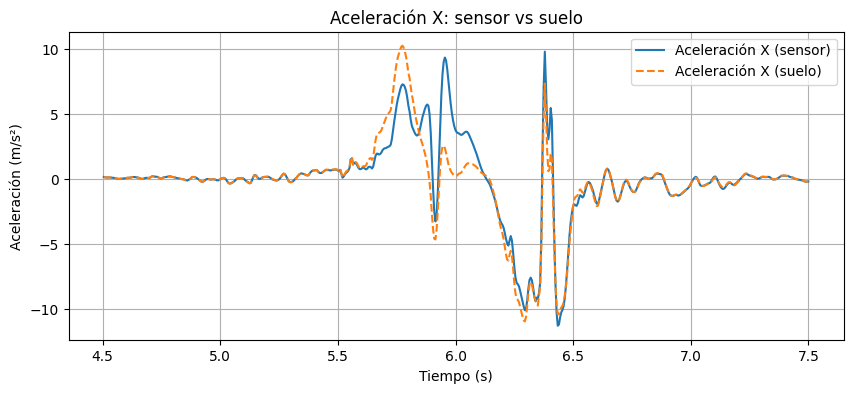

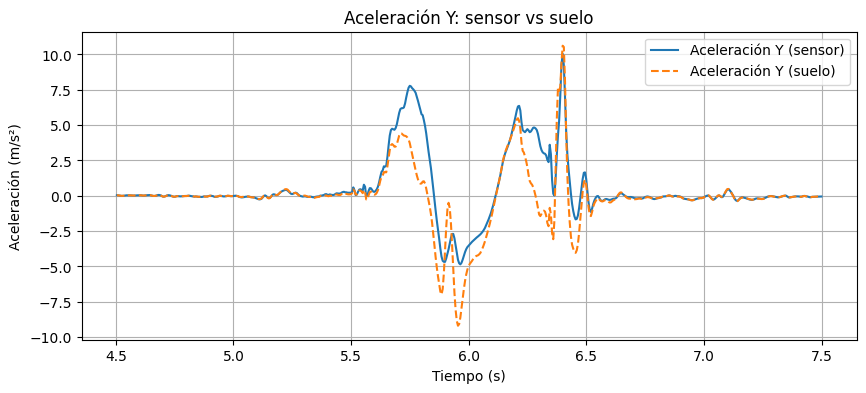

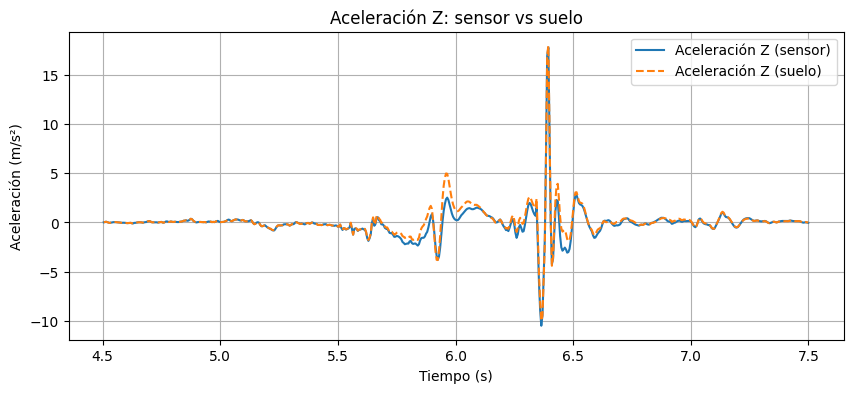

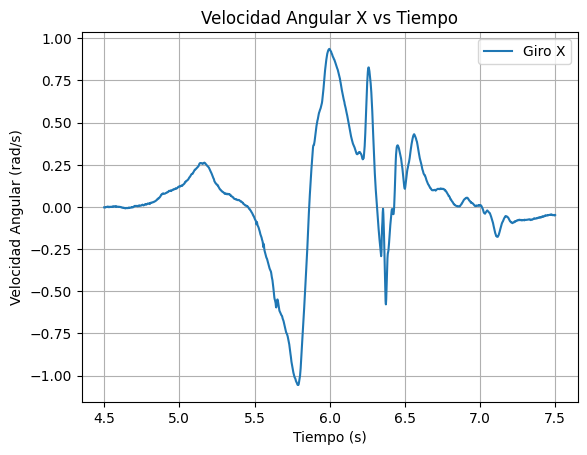

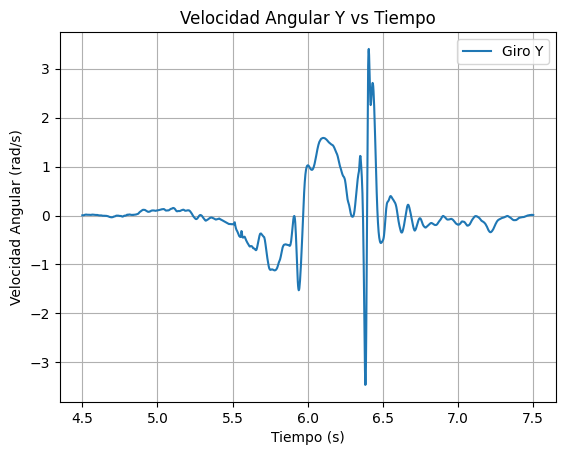

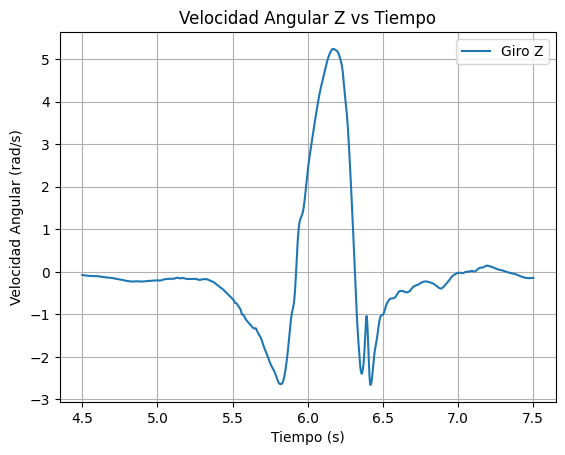

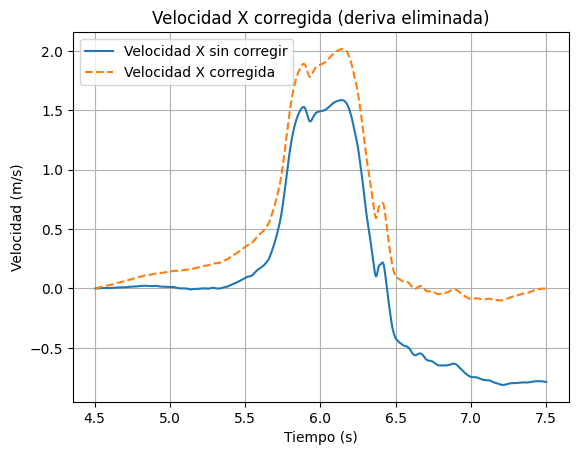

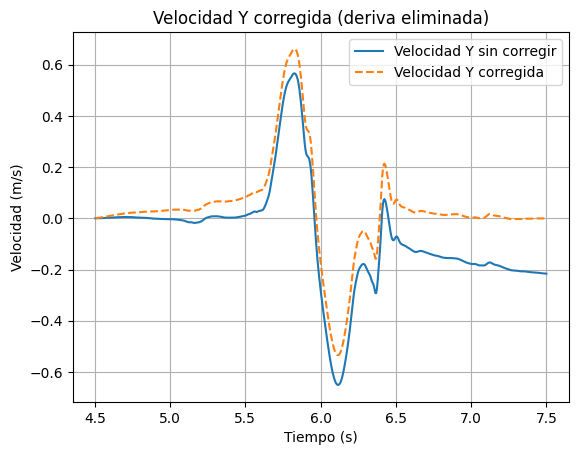

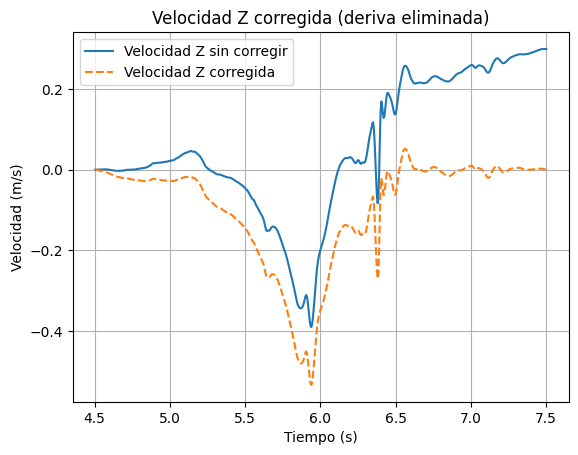

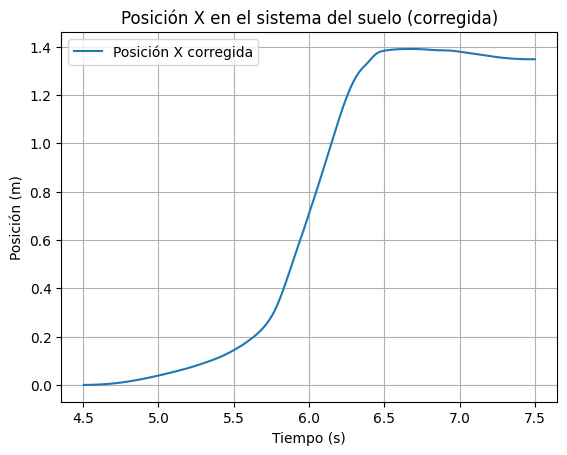

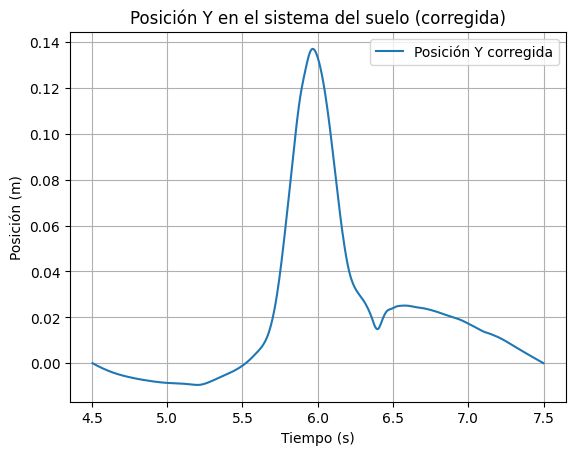

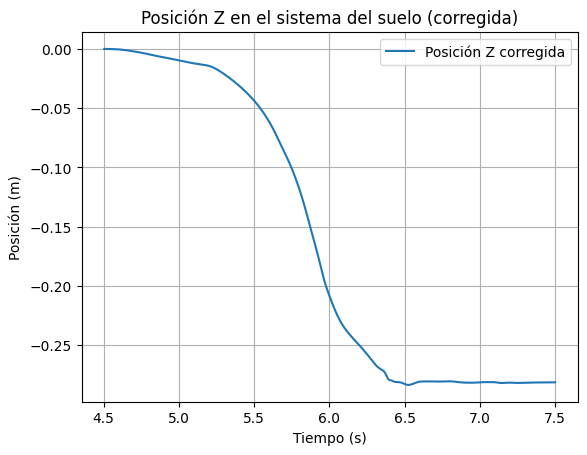

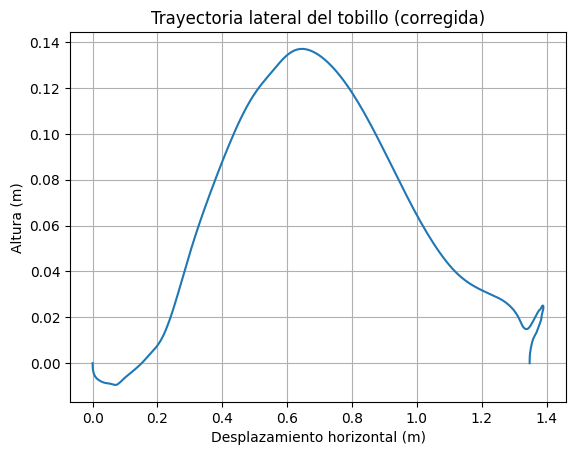

Longitud de zancada: 1.377 m
Altura máxima del tobillo: 0.137 m


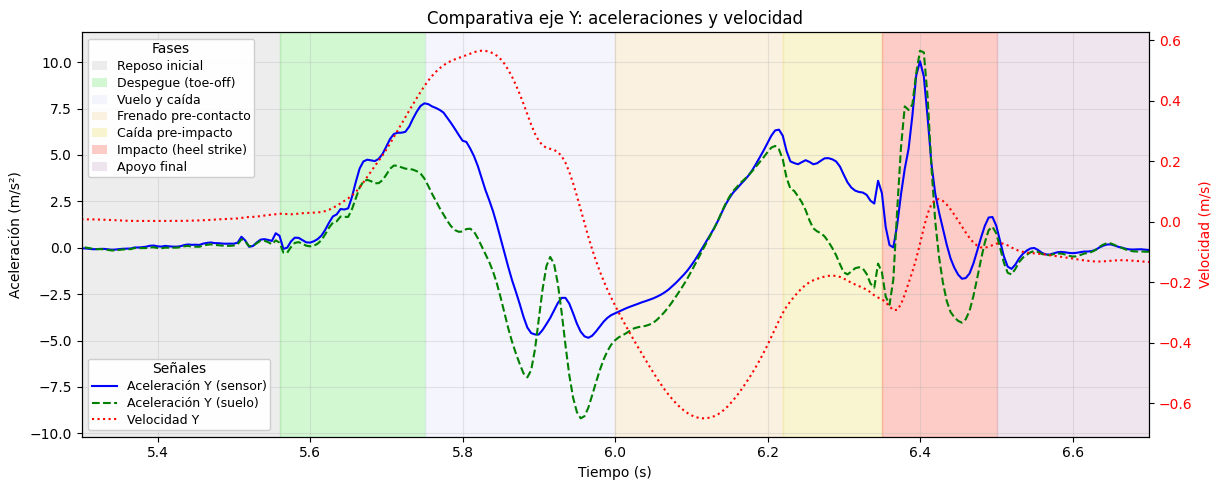

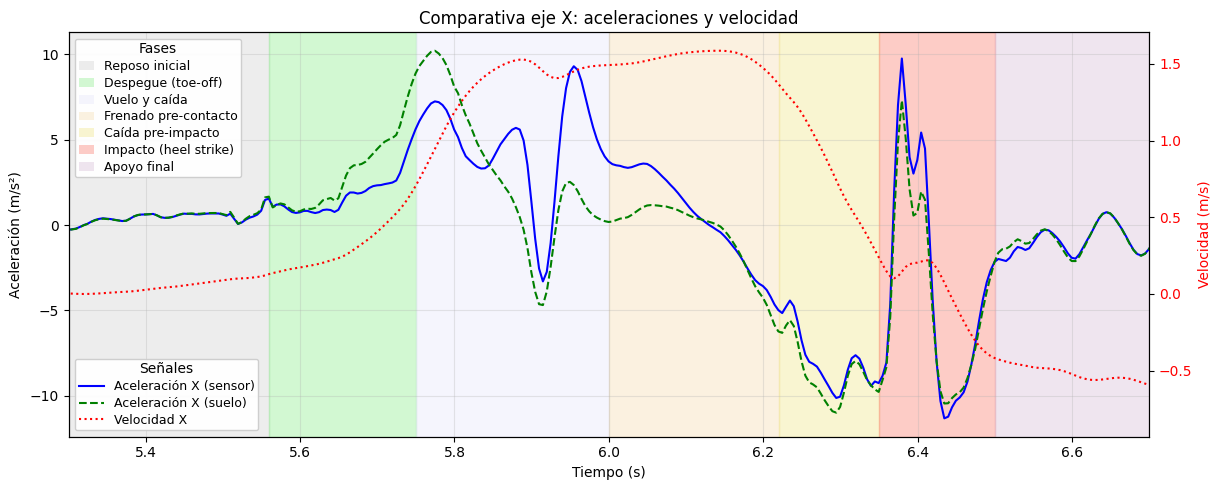

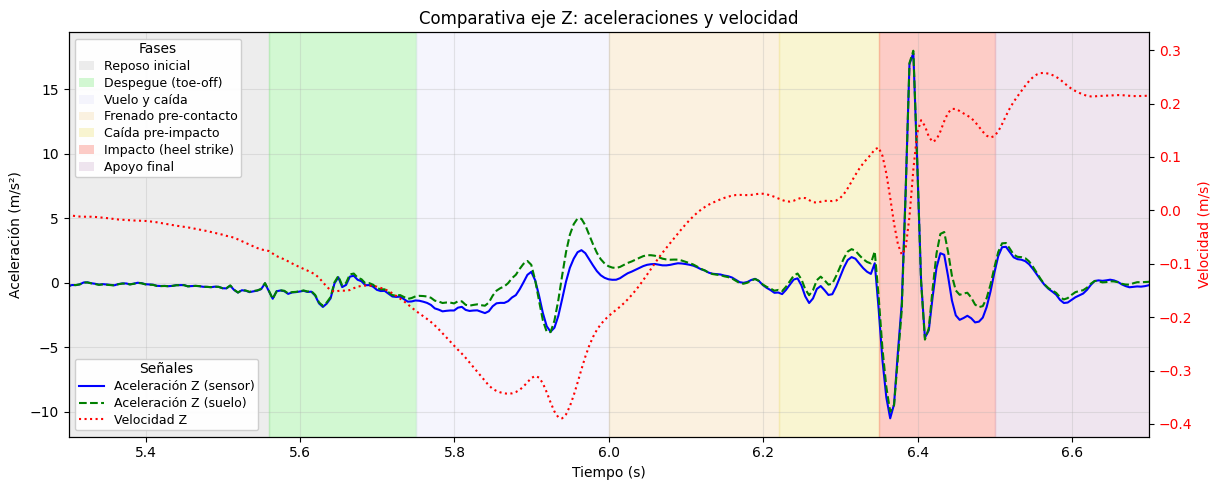

In [6]:
# Analisis del ciclo de paso completo, utilizando un algoritmo ZUPT para cumplir las condiciones de velocidad v_i = 0 para i=x,y,z y posición 
# y=0 al finalizar el paso.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# 1) Cargar datos
acc_df = pd.read_csv('Accelerometer.csv')
gyr_df = pd.read_csv('Gyroscope.csv')

# 2) Recortar intervalo 4.5–7.5 s
t0, t1 = 4.5 , 7.5
acc_df = acc_df[(acc_df['seconds_elapsed'] >= t0) & (acc_df['seconds_elapsed'] <= t1)].reset_index(drop=True)
gyr_df = gyr_df[(gyr_df['seconds_elapsed'] >= t0) & (gyr_df['seconds_elapsed'] <= t1)].reset_index(drop=True)

# 3) Interpolar giroscopio al tiempo del acelerómetro
acc_t = acc_df['seconds_elapsed'].values
gyr_t = gyr_df['seconds_elapsed'].values

gyro_interp = {}
for comp in ['x', 'y', 'z']:
    gyro_interp[comp] = np.interp(acc_t, gyr_t, gyr_df[comp].values)

# 4) Integrar orientación acumulando rotvecs
N = len(acc_t)
rots = [R.identity()]
for i in range(1, N):
    dt = acc_t[i] - acc_t[i-1]
    omega = np.array([gyro_interp['x'][i],
                      gyro_interp['y'][i],
                      gyro_interp['z'][i]])
    rotvec = omega * dt
    rots.append(rots[-1] * R.from_rotvec(rotvec))

# 5) Matrices de rotación
R_matrices = np.stack([r.as_matrix() for r in rots], axis=0)

# 6) Rotar aceleraciones al sistema del suelo
acc_sensor = acc_df[['x', 'y', 'z']].values
acc_lab = np.einsum('nij,nj->ni', R_matrices, acc_sensor)

# 7) Graficar aceleraciones originales y rotadas (lado a lado)
componentes = ['X', 'Y', 'Z']
for i, comp in enumerate(componentes):
    plt.figure(figsize=(10,4))
    plt.plot(acc_t, acc_sensor[:,i], label=f'Aceleración {comp} (sensor)')
    plt.plot(acc_t, acc_lab[:,i], '--', label=f'Aceleración {comp} (suelo)')
    plt.title(f'Aceleración {comp}: sensor vs suelo')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Aceleración (m/s²)')
    plt.legend()
    plt.grid()
    plt.show()

# 8) Graficar velocidades angulares originales
for comp in ['x', 'y', 'z']:
    plt.figure()
    plt.plot(gyr_t, gyr_df[comp].values, label=f'Giro {comp.upper()}')
    plt.title(f'Velocidad Angular {comp.upper()} vs Tiempo')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Velocidad Angular (rad/s)')
    plt.legend()
    plt.grid()
    plt.show()

# 9) Integración RK4 de aceleración -> velocidad
def integrate_rk4(time, signal):
    v = np.zeros_like(signal)
    for i in range(1, len(time)):
        dt = time[i] - time[i-1]
        k1 = signal[i-1]
        k2 = 0.5 * (signal[i-1] + signal[i])
        k3 = k2
        k4 = signal[i]
        v[i] = v[i-1] + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return v

vel_lab = integrate_rk4(acc_t, acc_lab)

# 10) Corrección de deriva en velocidad
vel_lab_corr = np.zeros_like(vel_lab)
for i in range(3):
    v_final = vel_lab[-1, i]
    drift = np.linspace(0, v_final, len(acc_t))
    vel_lab_corr[:, i] = vel_lab[:, i] - drift

# 11) Graficar velocidades corregidas
for i, comp in enumerate(componentes):
    plt.figure()
    plt.plot(acc_t, vel_lab[:,i], label=f'Velocidad {comp} sin corregir')
    plt.plot(acc_t, vel_lab_corr[:,i], '--', label=f'Velocidad {comp} corregida')
    plt.title(f'Velocidad {comp} corregida (deriva eliminada)')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Velocidad (m/s)')
    plt.legend()
    plt.grid()
    plt.show()

# 12) Integrar velocidad corregida -> posición
pos_lab = integrate_rk4(acc_t, vel_lab_corr)

# 13) Corrección de deriva en posición vertical
pos_lab_corr = pos_lab.copy()
dy = pos_lab[-1,1] - pos_lab[0,1]
drift_y = np.linspace(0, dy, len(acc_t))
pos_lab_corr[:,1] -= drift_y

# 14) Graficar posiciones corregidas
for i, comp in enumerate(componentes):
    plt.figure()
    plt.plot(acc_t, pos_lab_corr[:,i], label=f'Posición {comp} corregida')
    plt.title(f'Posición {comp} en el sistema del suelo (corregida)')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Posición (m)')
    plt.legend()
    plt.grid()
    plt.show()

# 15) Trayectoria lateral (horizontal vs altura)
# horiz = np.sqrt(pos_lab_corr[:,0]**2 + pos_lab_corr[:,2]**2)
horiz = pos_lab_corr[:, 0]
vert  = pos_lab_corr[:,1]

plt.figure()
plt.plot(horiz, vert)
plt.title('Trayectoria lateral del tobillo (corregida)')
plt.xlabel('Desplazamiento horizontal (m)')
plt.ylabel('Altura (m)')
plt.grid()
plt.show()

# Calcular longitud de zancada (desplazamiento horizontal neto)
X_final = pos_lab_corr[-1, 0]
Z_final = pos_lab_corr[-1, 2]
longitud_zancada = np.sqrt(X_final**2 + Z_final**2)

# Calcular altura máxima alcanzada
altura_maxima = np.max(pos_lab_corr[:, 1])

print(f'Longitud de zancada: {longitud_zancada:.3f} m')
print(f'Altura máxima del tobillo: {altura_maxima:.3f} m')

# =========================
# 16–18) Gráficas combinadas con dos leyendas
# =========================
from matplotlib.patches import Patch

# Paleta de fases (mismos intervalos que ya tienes)
subintervalos = [
    (5.3, 5.56, 'Reposo inicial',       'lightgray'),
    (5.56, 5.75, 'Despegue (toe-off)',  'lightgreen'),
    (5.75, 6.00, 'Vuelo y caída',       'lavender'),
    (6.00, 6.22, 'Frenado pre-contacto','wheat'),
    (6.22, 6.35, 'Caída pre-impacto',   'khaki'),
    (6.35, 6.50, 'Impacto (heel strike)','salmon'),
    (6.50, 6.70, 'Apoyo final',         'thistle')
]

# Parches para la leyenda de fases (una sola vez, sin duplicados)
phase_handles = [Patch(facecolor=c, edgecolor='none', alpha=0.4, label=lab)
                 for (_, _, lab, c) in subintervalos]

def grafica_combinada(comp_idx, nombre_comp):
    fig, ax1 = plt.subplots(figsize=(14, 5))

    # Aceleraciones (guardar handles explícitamente)
    l1, = ax1.plot(acc_t, acc_sensor[:, comp_idx],
                   label=f'Aceleración {nombre_comp} (sensor)', color='blue')
    l2, = ax1.plot(acc_t, acc_lab[:, comp_idx], '--',
                   label=f'Aceleración {nombre_comp} (suelo)', color='green')

    ax1.set_xlabel('Tiempo (s)')
    ax1.set_ylabel('Aceleración (m/s²)')
    ax1.set_xlim(5.3, 6.7)
    ax1.grid(True, alpha=0.3)

    # Fases (sombreado; SIN label aquí para no llenar la leyenda de líneas)
    for t_start, t_end, _, color in subintervalos:
        ax1.axvspan(t_start, t_end, color=color, alpha=0.4, zorder=0)

    # Velocidad del eje correspondiente (en rojo, eje derecho)
    ax2 = ax1.twinx()
    l3, = ax2.plot(acc_t, vel_lab[:, comp_idx], ':',
                   color='red', label=f'Velocidad {nombre_comp}')
    ax2.set_ylabel('Velocidad (m/s)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # --- LEYENDA DE FASES (arriba izquierda, fuera del área) ---
    leg_fases = ax1.legend(
        handles=phase_handles,
        loc='upper left',            # coloca la esquina superior-DCHA del recuadro...
        bbox_to_anchor=(0.0, 1.0),  # ...anclada un pelín a la IZQUIERDA del eje
        ncol=1,
        fontsize=9,
        framealpha=0.95,
        title='Fases',
        borderpad=0.3, labelspacing=0.3, handlelength=1.2
    )
    ax1.add_artist(leg_fases)  # conservarla al crear la segunda leyenda

    # --- LEYENDA DE SEÑALES (abajo izquierda, dentro del área) ---
    ax1.legend(handles=[l1, l2, l3],
               loc='lower left', fontsize=9, framealpha=0.95,
               title='Señales', borderpad=0.3, labelspacing=0.3,
               handlelength=2.0)

    plt.title(f'Comparativa eje {nombre_comp}: aceleraciones y velocidad')
    # deja sitio a la izquierda para la leyenda de fases externa
    plt.tight_layout(rect=[0.12, 0, 1, 1])  # aumenta 0.12 si necesitas más margen
    plt.show()

# Llamadas: Y, X, Z (en ese orden si lo prefieres)
grafica_combinada(1, 'Y')
grafica_combinada(0, 'X')
grafica_combinada(2, 'Z')
